# Vehicle Detection Project

The goals / steps of this project are the following:
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector.
- Normalize features and randomize a selection for training and testing.
- Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
- Run the pipeline on a video stream (first on the test_video.mp4 and later on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

## 1. HOG

In [1]:
import numpy as np
import cv2
import glob
import time
import collections

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

from moviepy.video.io.VideoFileClip import VideoFileClip

### 1.1 Read in training data

In [3]:
# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Check that arrays are not empty
print(cars[0])
print(notcars[0])

vehicles/GTI_Right/image0110.png
non-vehicles/GTI/image3419.png


### 1.2 Histogram of Oriented Gradients (HOG), Color histogram

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=True, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_feature = get_hog_features(feature_image[:, :, channel],
                                                   orient, pix_per_cell, cell_per_block,
                                                   vis=False, feature_vec=True)
                    hog_features.append(hog_feature)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### 1.3 Fix HOG parameters

In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#### Q1.1 Explain how you extracted HOG features from the training images.

I start by reading in the images of cars and non-cars from the dataset provided for this project. Examples of both types of images are shown below:

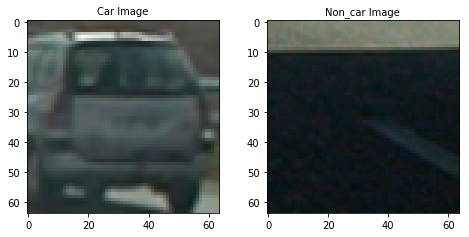

In [7]:
car_image = mpimg.imread(cars[0])
notcar_image = mpimg.imread(notcars[0])

f, (ax1, ax2) = plt.subplots(1, 2)
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(notcar_image)
ax2.set_title('Non_car Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Then I use the functions from the lesson `get_hog_features`, `bin_spatial`, `color_hist` and `extract_features` to extract the HOG features as well as color histogram features using the parameters fixed below. The extracted features for HOG and color histogram are then brought to the same scale using the sklearn function `StandardScaler`. 

As an example, HOG features for the 'R' channel of the above two sample images are plotted below.

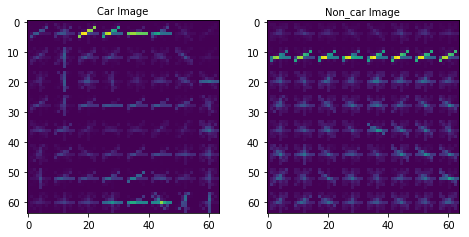

In [8]:
_, hog_car_image = get_hog_features(car_image[:,:,0], orient, pix_per_cell, cell_per_block)
_, hog_notcar_image = get_hog_features(notcar_image[:,:,0], orient, pix_per_cell, cell_per_block)

f, (ax1, ax2) = plt.subplots(1, 2)
f.tight_layout()
ax1.imshow(hog_car_image)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(hog_notcar_image)
ax2.set_title('Non_car Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Q1.2. Explain how you settled on your final choice of HOG parameters.

Most of the HOG parameters like `orient`, `pix_per_cell`, `cell_per_block`, etc. are left unchanged from the lesson, since their tweaking didn't impact the result much. However, modifying the `color_space` to 'YCrCb' improved the result. To illustrate, the HOG features for the `Cr` channel of the above two images, respectively, are plotted below:

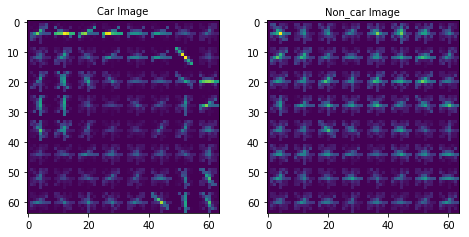

In [9]:
car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)

_, hog_car_image = get_hog_features(car_image[:,:,1], orient, pix_per_cell, cell_per_block)
_, hog_notcar_image = get_hog_features(notcar_image[:,:,1], orient, pix_per_cell, cell_per_block)

f, (ax1, ax2) = plt.subplots(1, 2)
f.tight_layout()
ax1.imshow(hog_car_image)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(hog_notcar_image)
ax2.set_title('Non_car Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 1.4 Extract and Scale features

In [10]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### 1.5 Split into Training and Test sets

In [11]:
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7824


### 1.6 Train classifier

In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

63.5498 Seconds to train SVC...
Test Accuracy of SVC =  0.98845721


#### Q1.3. Describe how you trained a classifier using your selected HOG features (and color features if you used them).

For training, as usual, I split the scaled data into training and test sets using the sklearn function `train_test_split` which also ensures that the data is randomly shuffled before split. Then, the classifier `LinearSVC` from sklearn is used for training without modifying the default parameters. 

### 2. Sliding Window Search

In [13]:
## 2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), polygon_mask=None):

    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1

    # Initialize a list to append window positions to
    window_list = []

    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            if polygon_mask is not None:
                if polygon_mask[int(starty)][int(startx)] > 0:
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
            else:
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [14]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)

In [15]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

In [16]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### 2.1 Fix Test Image

In [18]:
image = mpimg.imread('test_images/test5.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255

### 2.2 Fix Sliding Search Parameters

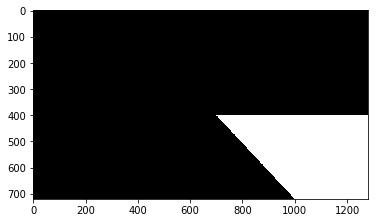

In [19]:
mask = np.zeros_like(image[:,:,0])
vertices = np.array([[(700,400),(1000,720),(1280,720),(1280,400)]])
mask = cv2.fillPoly(mask, vertices, 1)
plt.imshow(mask, cmap="gray")

In [20]:
window_sizes = [ 64, 96, 128]

y_start_stop = [ [400, 650], [430, 680], [470, 720]]

windows = []
for i in range(len(window_sizes)):
   windows += slide_window(
       image, x_start_stop=[None, None], y_start_stop=y_start_stop[i],
       xy_window=(window_sizes[i], window_sizes[i]), xy_overlap=(0.8, 0.8), polygon_mask = mask
   )

#### Q2.1. Describe how you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

Sliding windows of different sizes are run across a portion of the lower half of the image. The search is restricted to the lower half to avoid detection of cars in the sky, for example. Even in the lower half, the search is restricted depending on the window size being used, the intuition being that cars would appear larger when near the bottom of the image, and will progressively diminish as they move up the image.
Finally, a mask is applied to retain only those detections which fall within a certain region of interest.

#### Q2.2 Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?

The pipeline has been applied below to the test image. Apart from the aforementioned tweaks for better performance, a higher value of window overlap (compared to the one used in lesson) is used, since it allows for better thresholding using heatmap. For a single image, heatmap of thresholding of 1 tends to work fine.

In [21]:
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

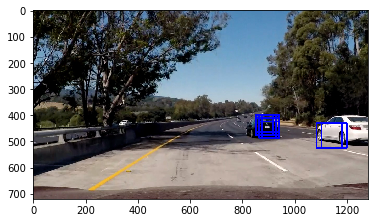

In [22]:
plt.imshow(window_img)
plt.show()

### 2.3 Heatmap for a single image

In [23]:
def add_heat(img, boxes):
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
    # Iterate through list of bboxes
    for box in boxes:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [24]:
# Combine multiple detections
def draw_labeled_bboxes(img, labels):
    imcopy = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return imcopy

In [25]:
heatmap = add_heat(image, hot_windows)
heatmap = apply_threshold(heatmap,1)
labels = label(heatmap)
window_img_heat = draw_labeled_bboxes(draw_image, labels)

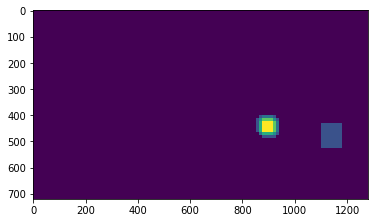

In [26]:
plt.imshow(heatmap)
plt.show()

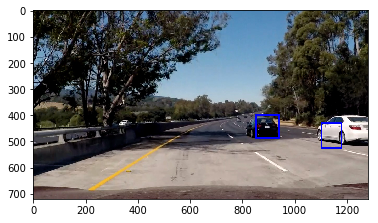

In [27]:
plt.imshow(window_img_heat)
plt.show()

## 3. Video Implementation

### 3.1 Heatmap for video

In [28]:
def heat_multi_frames(img, boxes_list, v_threshold):
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
    
    for boxes in boxes_list:
        for box in boxes:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return apply_threshold(heatmap, v_threshold)

In [29]:
def process_frame(img):
    draw_image = np.copy(img)
    img = img.astype(np.float32) / 255

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)
    frameboxes_list.append(hot_windows)
    heatmap = heat_multi_frames(img, frameboxes_list, 10)

    labels = label(heatmap)

    return draw_labeled_bboxes(draw_image, labels)

In [30]:
frameboxes_list = collections.deque(maxlen=10)

project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
window_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time window_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [2:15:10<00:06,  6.39s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2h 7min 48s, sys: 1min 1s, total: 2h 8min 49s
Wall time: 2h 15min 13s


#### Q3.1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Please find the 'project_video_output.mp4' zipped along with other submitted files. 

#### Q3.2. Describe how you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

To control for false positives in a single frame, I generated heatmap from detections in the preceding (upto) 10 frames, and then apply the threshold of 10. This eliminates the stray detections in any single frame. 

## 4.Discussion

#### Q4.1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust? 

There are, in general, a fair amount of stray detections, that is, false positives, and the strategies implemented for their elimination, like masking the region of uninterest and heatmap-thresholding, are ad-hoc, and will likely fail when driving conditions change, for example, curvature and slope of road, surroundings, and lighting conditions.